In [19]:
#imports & configuration
import os, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

CSV_PATH = "/kaggle/input/exoset/exoTrain.csv"   
SEED = 42
N_SPLITS = 5
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DOWNSAMPLE_TO = 800        # or None
SG_WINDOW = 101
SG_POLY = 2
GAUSS_SIGMA = 1.0
EARLY_STOPPING = 6
WEIGHT_DECAY = 1e-5

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

In [20]:
# loading data and quick EDA
df = pd.read_csv(CSV_PATH)
print("Columns:", df.columns.tolist()[:20])
if 'LABEL' not in df.columns:
    raise RuntimeError("CSV must contain a 'LABEL' column.")

y_raw = df['LABEL'].values
y = np.where(y_raw == 1, 1, 0).astype(int)
print("Label counts:", np.bincount(y))

flux_cols = [c for c in df.columns if c.upper().startswith("FLUX")]
print("Found flux columns:", len(flux_cols))
# show a few raw rows
display(df.loc[:3, flux_cols].head())

Columns: ['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6', 'FLUX.7', 'FLUX.8', 'FLUX.9', 'FLUX.10', 'FLUX.11', 'FLUX.12', 'FLUX.13', 'FLUX.14', 'FLUX.15', 'FLUX.16', 'FLUX.17', 'FLUX.18', 'FLUX.19']
Label counts: [  37 5050]
Found flux columns: 3197


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98


In [21]:
# preprocessing function
def preprocess_flux_vector_simple(x, sg_window=SG_WINDOW, sg_poly=SG_POLY,
                                  gauss_sigma=GAUSS_SIGMA, downsample_to=DOWNSAMPLE_TO):
    x = np.asarray(x, dtype=np.float64)
    # median subtract
    med = np.median(x); x = x - med

    # Savitzky-Golay detrend if window valid
    sw = sg_window
    if sw >= len(x):
        new_w = len(x) - 1
        if new_w % 2 == 0:
            new_w -= 1
        if new_w >= 3:
            sw = new_w
    if sw >= 3:
        try:
            trend = savgol_filter(x, window_length=sw, polyorder=sg_poly, mode='interp')
            x = x - trend
        except Exception:
            pass

    # Gaussian smoothing
    if gauss_sigma and gauss_sigma > 0:
        x = gaussian_filter1d(x, sigma=gauss_sigma)

    # robust standardize: median + MAD -> approx Gaussian scaling
    med2 = np.median(x)
    mad = np.median(np.abs(x - med2)) * 1.4826
    if mad <= 0:
        mad = np.std(x) + 1e-8
    x = (x - med2) / (mad + 1e-12)

    # downsample (linear interpolation)
    if downsample_to is not None and downsample_to < len(x):
        idx = np.linspace(0, len(x) - 1, downsample_to)
        low = np.floor(idx).astype(int)
        high = np.ceil(idx).astype(int)
        high[high >= len(x)] = len(x) - 1
        frac = idx - low
        x = (1 - frac) * x[low] + frac * x[high]

    return x.astype(np.float32)

In [22]:
# preprocess dataset into X_proc
X_proc = []
for i, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
    raw = row[flux_cols].values
    proc = preprocess_flux_vector_simple(raw, downsample_to=DOWNSAMPLE_TO)
    X_proc.append(proc)
X_proc = np.stack(X_proc)   # shape (N, L)
print("Processed shape:", X_proc.shape)

Preprocessing: 100%|██████████| 5087/5087 [00:14<00:00, 350.73it/s]

Processed shape: (5087, 800)


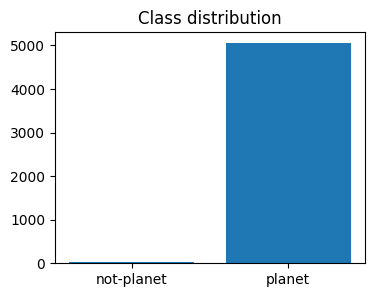

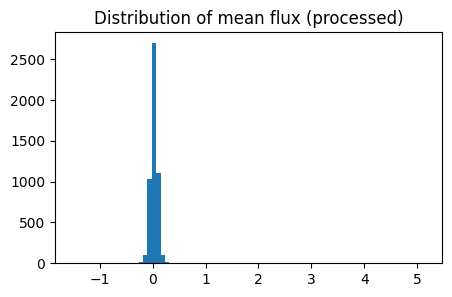

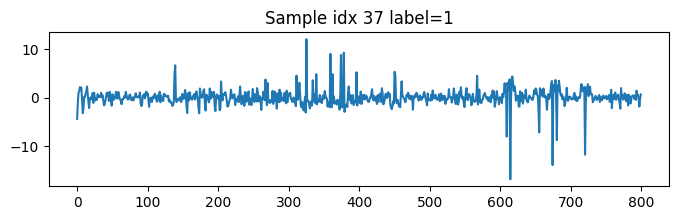

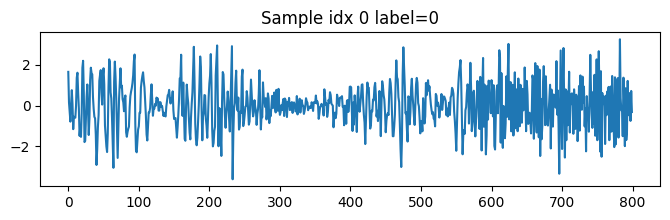

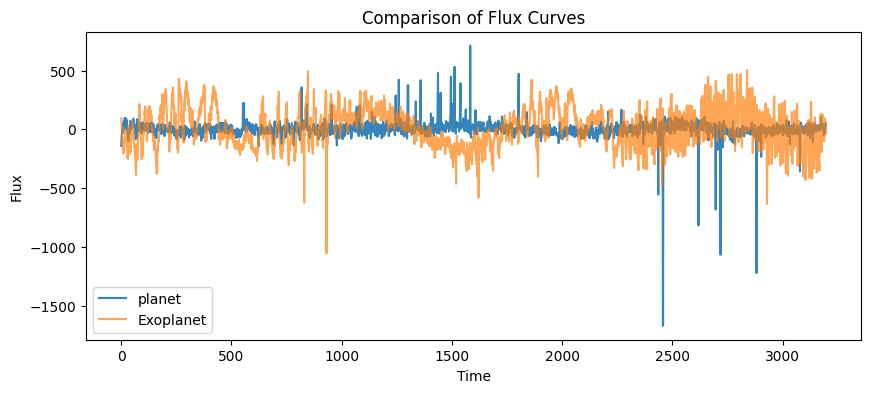

In [23]:
# EDA plots
import matplotlib.pyplot as plt

# class distribution
plt.figure(figsize=(4,3))
plt.bar([0,1], np.bincount(y))
plt.xticks([0,1], ['not-planet','planet'])
plt.title("Class distribution"); plt.show()

# distribution of per-sample mean flux (after preproc)
means = X_proc.mean(axis=1)
plt.figure(figsize=(5,3))
plt.hist(means, bins=80)
plt.title("Distribution of mean flux (processed)"); plt.show()

# plot a few samples (one planet, one not)
idx_planet = np.where(y==1)[0]
idx_not = np.where(y==0)[0]
for idx in [idx_planet[0], idx_not[0]]:
    plt.figure(figsize=(8,2))
    plt.plot(X_proc[idx])
    plt.title(f"Sample idx {idx} label={y[idx]}")
    plt.show()

planet = df[df['LABEL'] == 1].iloc[0,1:].values
nonplanet = df[df['LABEL'] == 2].iloc[0,1:].values

plt.figure(figsize=(10,4))
plt.plot(planet, label="planet", alpha=0.9)
plt.plot(nonplanet, label="Exoplanet", alpha=0.7)
plt.legend()
plt.title("Comparison of Flux Curves")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

In [24]:
#torch Dataset
class ExoDatasetSimple(torch.utils.data.Dataset):
    def __init__(self, X_proc, y, augment=False):
        self.X = X_proc.astype(np.float32)
        self.y = y.astype(np.int64)
        self.augment = augment
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx].copy()
        if self.augment:
            # small augmentations: jitter and scaling
            if np.random.rand() < 0.5:
                x = x + np.random.normal(0, 0.02, size=x.shape)
            if np.random.rand() < 0.2:
                s = np.random.uniform(0.98, 1.02); x = x * s
        return torch.tensor(x, dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.long)

In [25]:
#1D CNN model
class SimpleCNN(nn.Module):
    def __init__(self, seq_len, in_ch=1, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, 16, kernel_size=11, padding=5),
            nn.BatchNorm1d(16), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=9, padding=4),
            nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64), nn.ReLU(), nn.AdaptiveAvgPool1d(1)
        )
        self.embed_dim = 64
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        out = self.conv(x)             # shape (N, C, 1)
        out = out.view(out.size(0), -1)
        logits = self.classifier(out)
        return logits

In [26]:
# SKFold training + OOF collection
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof_targets = []
oof_probs = []
oof_preds = []
oof_idx = []
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_proc, y), start=1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X_proc[train_idx], X_proc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_ds = ExoDatasetSimple(X_train, y_train, augment=True)
    val_ds = ExoDatasetSimple(X_val, y_val, augment=False)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleCNN(seq_len=X_proc.shape[1]).to(DEVICE)
    counts = np.bincount(y_train); counts = np.where(counts==0,1,counts)
    class_weights = torch.tensor((len(y_train) / (2.0 * counts)), dtype=torch.float32).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val_f1 = 0.0; patience = 0
    best_state = None; best_thresh = 0.5

    for epoch in range(1, EPOCHS+1):
        # train
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward(); optimizer.step()
            train_losses.append(loss.item())
        train_loss = float(np.mean(train_losses))

        # val eval
        model.eval()
        val_probs = []; val_targets = []; val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                logits = model(xb)
                val_losses.append(criterion(logits, yb).item())
                probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
                val_probs.extend(probs.tolist())
                val_targets.extend(yb.cpu().numpy().tolist())
        val_loss = float(np.mean(val_losses)) if val_losses else 0.0

        if len(np.unique(val_targets)) > 1:
            prec, rec, th = precision_recall_curve(val_targets, val_probs)
            f1s = 2*prec*rec/(prec+rec+1e-12)
            best_idx = int(np.nanargmax(f1s))
            epoch_thresh = float(th[best_idx]) if best_idx < len(th) else 0.5
            epoch_val_f1 = float(np.nanmax(f1s))
        else:
            epoch_thresh = 0.5; epoch_val_f1 = 0.0

        print(f"Epoch {epoch} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={epoch_val_f1:.4f}")

        if epoch_val_f1 > best_val_f1 + 1e-6:
            best_val_f1 = epoch_val_f1
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            best_thresh = epoch_thresh
            patience = 0
        else:
            patience += 1
            if patience >= EARLY_STOPPING:
                print("Early stopping.")
                break

    # restore best model
    if best_state is not None:
        model.load_state_dict(best_state)
    thresh = best_thresh if best_thresh is not None else 0.5
    print("Using threshold for fold:", thresh)

    # compute val oof predictions
    model.eval()
    val_probs = []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            val_probs.extend(probs.tolist())
    val_probs = np.array(val_probs)
    val_preds = (val_probs >= thresh).astype(int)

    # accumulate OOF info
    oof_targets.extend(y[val_idx].tolist())
    oof_probs.extend(val_probs.tolist())
    oof_preds.extend(val_preds.tolist())
    oof_idx.extend(val_idx.tolist())

    # fold metrics
    acc = accuracy_score(y[val_idx], val_preds)
    prec = precision_score(y[val_idx], val_preds, zero_division=0)
    rec = recall_score(y[val_idx], val_preds, zero_division=0)
    f1 = f1_score(y[val_idx], val_preds, zero_division=0)
    try:
        roc = roc_auc_score(y[val_idx], val_probs)
    except:
        roc = float('nan')
    fold_results.append({'fold':fold,'acc':acc,'prec':prec,'rec':rec,'f1':f1,'roc':roc})
    print(f"Fold {fold} VAL metrics: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, ROC AUC={roc:.4f}")


--- Fold 1 ---
Epoch 1 train_loss=0.3755 val_loss=0.1167 val_f1=0.9961
Epoch 2 train_loss=0.3305 val_loss=0.2242 val_f1=0.9961
Epoch 3 train_loss=0.2458 val_loss=0.9165 val_f1=0.9961
Epoch 4 train_loss=0.2454 val_loss=0.2926 val_f1=0.9961
Epoch 5 train_loss=0.2075 val_loss=0.6269 val_f1=0.9961
Epoch 6 train_loss=0.1553 val_loss=0.0962 val_f1=0.9961
Epoch 7 train_loss=0.1428 val_loss=0.2484 val_f1=0.9961
Early stopping.
Using threshold for fold: 0.7128878831863403
Fold 1 VAL metrics: Acc=0.9921, Prec=0.9921, Rec=1.0000, F1=0.9961, ROC AUC=0.8744

--- Fold 2 ---
Epoch 1 train_loss=0.3825 val_loss=0.2293 val_f1=0.9965
Epoch 2 train_loss=0.2939 val_loss=0.1346 val_f1=0.9961
Epoch 3 train_loss=0.2179 val_loss=0.1864 val_f1=0.9965
Epoch 4 train_loss=0.2035 val_loss=0.2448 val_f1=0.9961
Epoch 5 train_loss=0.1569 val_loss=0.1241 val_f1=0.9961
Epoch 6 train_loss=0.1217 val_loss=0.2565 val_f1=0.9970
Epoch 7 train_loss=0.1221 val_loss=0.3013 val_f1=0.9965
Epoch 8 train_loss=0.0815 val_loss=0.146

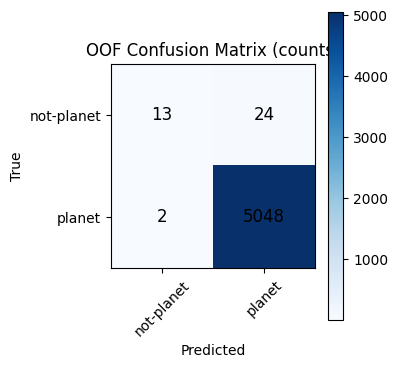

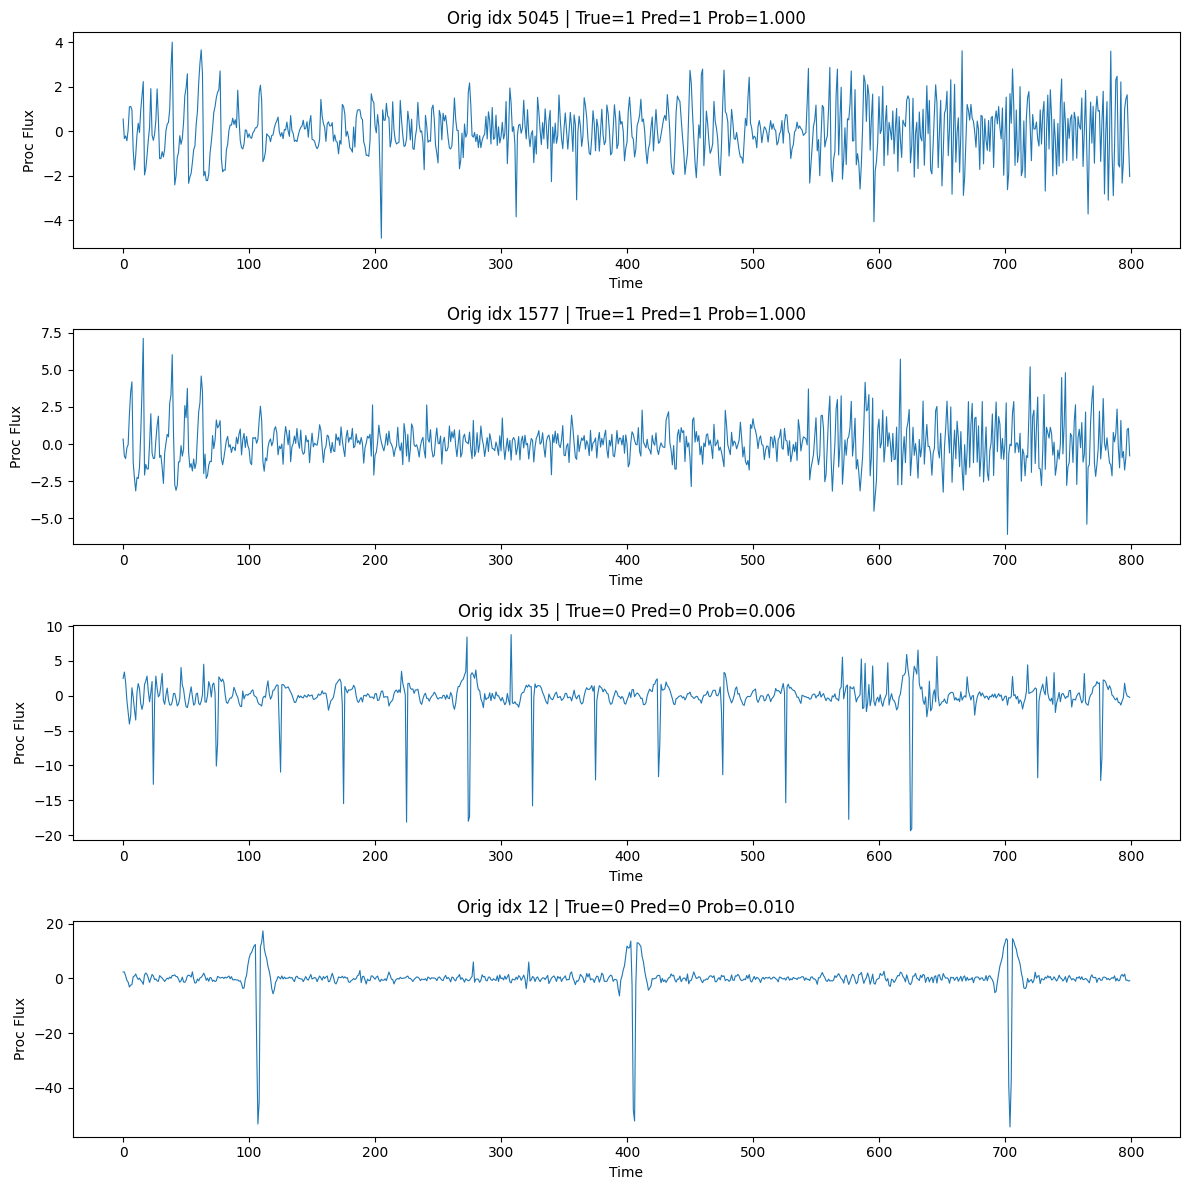

In [28]:
# final OOF aggregation + plots: show OOF CM and 4 examples
oof_targets = np.array(oof_targets, dtype=int)
oof_probs   = np.array(oof_probs, dtype=float)
oof_preds   = np.array(oof_preds, dtype=int)
oof_idx     = np.array(oof_idx, dtype=int)

# OOF confusion matrix (counts)
cm_oof = confusion_matrix(oof_targets, oof_preds, labels=[0,1])
plt.figure(figsize=(4,4))
plt.imshow(cm_oof, cmap='Blues')
plt.title("OOF Confusion Matrix (counts)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ['not-planet','planet'], rotation=45); plt.yticks([0,1], ['not-planet','planet'])
for i,j in itertools.product(range(cm_oof.shape[0]), range(cm_oof.shape[1])):
    plt.text(j, i, f"{int(cm_oof[i,j])}", ha="center", va="center", color="black", fontsize=12)
plt.colorbar(); plt.tight_layout(); plt.show()


tp_idx = np.where((oof_targets == 1) & (oof_preds == 1))[0]  # true positives
tn_idx = np.where((oof_targets == 0) & (oof_preds == 0))[0]  # true negatives

examples = []
if len(tp_idx) > 0:
    conf_tp = oof_probs[tp_idx]  
    top_tp = tp_idx[np.argsort(-conf_tp)][:2]
    examples.extend(top_tp.tolist())

if len(tn_idx) > 0:
    conf_tn = 1.0 - oof_probs[tn_idx]  
    top_tn = tn_idx[np.argsort(-conf_tn)][:2]
    examples.extend(top_tn.tolist())

if len(examples) < 4:
    corr_idx = np.where(oof_preds == oof_targets)[0]
    need = 4 - len(examples)
    if len(corr_idx) > 0:
        conf_corr = np.abs(oof_probs[corr_idx] - 0.5)
        more = corr_idx[np.argsort(-conf_corr)][:need]
        for m in more:
            if m not in examples:
                examples.append(int(m))

if len(examples) == 0:
    print("No examples to show.")
else:
    plt.figure(figsize=(12, 3 * len(examples)))
    for i, oof_rel in enumerate(examples):
        orig_idx = int(oof_idx[oof_rel])
        seq = X_proc[orig_idx]
        true = int(oof_targets[oof_rel]); pred = int(oof_preds[oof_rel]); prob = float(oof_probs[oof_rel])
        plt.subplot(len(examples), 1, i+1)
        plt.plot(seq, lw=0.8)
        plt.title(f"Orig idx {orig_idx} | True={true} Pred={pred} Prob={prob:.3f}")
        plt.xlabel("Time"); plt.ylabel("Proc Flux")
    plt.tight_layout(); plt.show()